Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

/usr/local/Cellar/python/2.7.12/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def generate_word_to_index_dict(words_count):
    word_to_index_dict = dict()

    for word, _ in words_count:
        word_to_index_dict[word] = len(word_to_index_dict)
    
    return word_to_index_dict

def generate_corpus_in_index(corpus_in_words, word_to_index_dict):
    unk_count  = 0
    
    corpus_in_index = list()
    
    for word in corpus_in_words:
        if word in word_to_index_dict:
            word_index = word_to_index_dict[word]
        else:
            word_index = 0  # this word is labeled as UNK
            unk_count = unk_count + 1
        corpus_in_index.append(word_index)
        
    return corpus_in_index, unk_count

def build_dataset(corpus_in_words):
    words_count = [['UNK', -1]]
    
    words_count.extend(collections.Counter(words).most_common(vocabulary_size - 1))

    word_to_index_dict = generate_word_to_index_dict(words_count)
    
    corpus_in_index, unk_count = generate_corpus_in_index(corpus_in_words, word_to_index_dict)

    words_count[0][1] = unk_count
    
    index_to_word_dict = dict(zip(word_to_index_dict.values(), word_to_index_dict.keys())) 
    
    return corpus_in_index, words_count, word_to_index_dict, index_to_word_dict

corpus_in_index, words_count, word_to_index_dict, index_to_word_dict = build_dataset(words)
print('Most common words (+UNK)', words_count[:5])
print('Sample data', corpus_in_index[:10])
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def init_deque_buffer(corpus_in_index, skip_window, data_index):    
    span = 2 * skip_window + 1
    
    buffer = collections.deque(maxlen=span)
    
    for _ in range(span):
        buffer.append(corpus_in_index[data_index])
        data_index = (data_index + 1) % len(corpus_in_index)
    
    return buffer

def get_center_word_and_context_words_from_buffer(num_skips, skip_window, deque_buffer):
    span = skip_window * 2 + 1
    target = skip_window
    targets_to_avoid = [skip_window]
    
    center_word = []
    context_words = []
    
    for i in range(num_skips):
        while target in targets_to_avoid:
            target = random.randint(0, span - 1)
        targets_to_avoid.append(target)
        
        center_word.append(deque_buffer[skip_window])
        context_words.append(deque_buffer[target])
    return center_word, context_words


# skip_window is the number of words on the target's letf or right side. the whole span should be skip_windw * 2 + 1
# num_skip is the number of skips, one skip is the target word's label
def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  
    buffer = init_deque_buffer(corpus_in_index, skip_window, data_index)
    data_index += 2*skip_window + 1
# construct the batch. take num_skip samples from each buffer.
    for i in range(batch_size // num_skips):
        batch_buffer, label_buffer = get_center_word_and_context_words_from_buffer(num_skips, skip_window, buffer)
        
        batch[i * num_skips: i * num_skips + num_skips] = batch_buffer[:]
        labels[i * num_skips: i * num_skips + num_skips, 0] = label_buffer[:]
        
        buffer.append(corpus_in_index[data_index])
        data_index = (data_index + 1) % len(corpus_in_index)
    return batch, labels

print('data:', [index_to_word_dict[word_index] for word_index in corpus_in_index[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [index_to_word_dict[bi] for bi in batch])
    print('    labels:', [index_to_word_dict[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['anarchism', 'as', 'a', 'originated', 'term', 'as', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['a', 'term', 'originated', 'anarchism', 'originated', 'of', 'as', 'term']


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))

num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    # softmax layer weights, initialized using normal distribution.
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
    # softmax layer biases, initialized using normal distribution.
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases,train_labels, embed, num_sampled, vocabulary_size))

    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
    
    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
num_steps = 6001

def output_similiar_words(similarity, valid_examples, valid_size):
    top_k = 8
    for i in range(valid_size):
        valid_word = index_to_word_dict[valid_examples[i]]
        output_log = "Nearest to %s" % valid_word
        nearest = (-sim[i,:]).argsort()[1:top_k + 1]
        for k in range(top_k):
            kth_closest_word = index_to_word_dict[nearest[k]]
            output_log = "%s %s," % (output_log, kth_closest_word)
        print(output_log)
        

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    average_loss = 0
    for step in range(num_steps):
        batch_data, batch_labels = generate_batch(
          batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, loss_eval = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += loss_eval
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            output_similiar_words(sim, valid_examples, valid_size)
    final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.498913
Nearest to is simile, unwin, occultist, pindar, distracting, depicts, kepler, magneto,
Nearest to system implies, entombed, underlie, ourselves, royalties, cyberpunk, embittered, shuffle,
Nearest to its kublai, congratulated, vga, amundsen, warheads, gallon, colt, precedent,
Nearest to that bitch, maghreb, japh, randle, sender, contemporaneous, fullmetal, marshallese,
Nearest to to possessive, nowadays, mus, foe, behaviours, aggregation, britons, amplifier,
Nearest to at bullseye, eiji, mcdaniel, kirchenmusik, strikers, circumvent, canova, pli,
Nearest to on nusa, reconquest, sandalwood, podcast, everly, stair, martha, thinly,
Nearest to eight sorcery, bear, gobi, seventy, rewrote, unmatched, thrillers, casino,
Nearest to were pancakes, translates, gonzaga, gestapo, eschewing, fecal, alternating, lothal,
Nearest to called slums, outsider, ingredients, meccans, rigidity, tandem, intifada, hamlin,
Nearest to will avtovaz, sibelius, knuckle, he

In [8]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

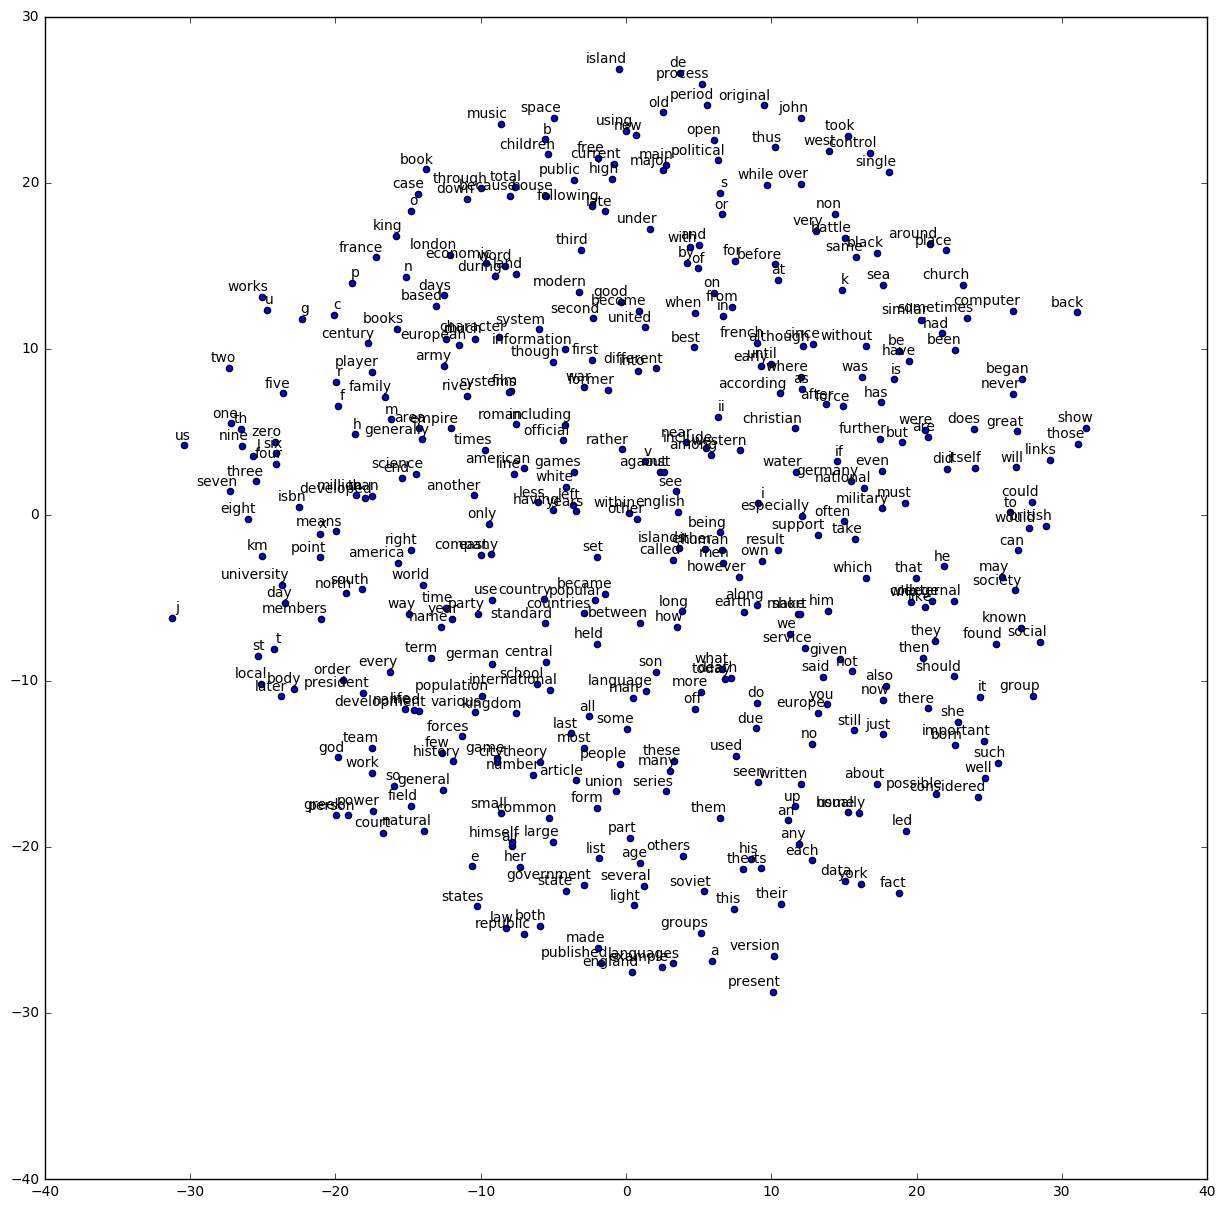

In [9]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [index_to_word_dict[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

Refer [Alex Minnaar's post](http://mccormickml.com/assets/word2vec/Alex_Minnaar_Word2Vec_Tutorial_Part_II_The_Continuous_Bag-of-Words_Model.pdf) to find out how to construct CBOW model.

In [10]:
DATA_INDEX = 0

def generate_batch_for_cbow_model(batch_size, num_skips, skip_window):
    global DATA_INDEX
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    
    batch = np.ndarray(shape=(batch_size, num_skips), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    
    buffer = init_deque_buffer(corpus_in_index, skip_window, DATA_INDEX)
    DATA_INDEX += 2 * skip_window + 1
    for i in range(batch_size):
        center_word, context_words = get_center_word_and_context_words_from_buffer(num_skips, skip_window, buffer)
        center_word = list(set(center_word))
        batch[i, :] = context_words[:] 
        labels[i, 0] = center_word[0]
        buffer.append(corpus_in_index[DATA_INDEX])
        DATA_INDEX = (DATA_INDEX + 1) % len(corpus_in_index)
    return batch, labels

print('data:', [index_to_word_dict[word_index] for word_index in corpus_in_index[:10]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    DATA_INDEX = 0
    batch, labels = generate_batch_for_cbow_model(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [[index_to_word_dict[context_word_index] for context_word_index in context_words] for context_words in batch])
    print('    labels:', [index_to_word_dict[li[0]] for li in labels])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with num_skips = 2 and skip_window = 1:
    batch: [['anarchism', 'as'], ['originated', 'a'], ['as', 'term'], ['of', 'a'], ['term', 'abuse'], ['of', 'first'], ['abuse', 'used'], ['first', 'against']]
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with num_skips = 4 and skip_window = 2:
    batch: [['originated', 'term', 'a', 'anarchism'], ['as', 'term', 'of', 'originated'], ['abuse', 'a', 'of', 'as'], ['term', 'a', 'first', 'abuse'], ['first', 'of', 'used', 'term'], ['used', 'against', 'abuse', 'of'], ['first', 'against', 'early', 'abuse'], ['working', 'used', 'first', 'early']]
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [11]:
num_sampled = 64
batch_size = 128
embedding_size = 128
skip_window = 1
num_skips = 2

valid_size = 16
valid_window = 100
valid_examples = np.array(random.sample(range(valid_window), valid_size))

cbow_graph = tf.Graph()
with cbow_graph.as_default():
    train_dataset = tf.placeholder(shape=[batch_size, num_skips], dtype=tf.int32)
    train_labels = tf.placeholder(shape=[batch_size, 1], dtype=tf.int32)
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
    
    embeddings = tf.Variable(tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    
    softmax_layer_weights = tf.Variable(tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_layer_biases = tf.Variable(tf.zeros([vocabulary_size]))
    
    embed_raw = tf.nn.embedding_lookup(embeddings, train_dataset)
    
    embed = tf.reduce_mean(embed_raw, axis = 1)
    
    loss = tf.reduce_mean(
        tf.nn.sampled_softmax_loss(softmax_layer_weights, softmax_layer_biases,train_labels, embed, num_sampled, vocabulary_size))
    
    optimizer = tf.train.AdamOptimizer(1e-3).minimize(loss)
    
    #validate model. Compute distance between valid_dataset and all embeddings
    #use consin distance
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
        normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [12]:
def output_similiar_words(similarity, valid_examples, valid_size):
    top_k = 8
    for i in range(valid_size):
        valid_word = index_to_word_dict[valid_examples[i]]
        output_log = "Nearest to %s" % valid_word
        nearest = (-sim[i,:]).argsort()[1:top_k + 1]
        for k in range(top_k):
            kth_closest_word = index_to_word_dict[nearest[k]]
            output_log = "%s %s," % (output_log, kth_closest_word)
        print(output_log)

DATA_INDEX = 0
steps = 6001
with tf.Session(graph=cbow_graph) as session:
    tf.global_variables_initializer().run()
    average_loss = 0
    for step in range(steps):
        batch_data, batch_label = generate_batch_for_cbow_model(batch_size, num_skips, skip_window)
        feed_dict = {train_dataset: batch_data, train_labels: batch_label}
        _, loss_eval, embed_raw_eval, embed_eval = session.run([optimizer, loss, embed_raw, embed], feed_dict)
        average_loss +=loss_eval
        if step % 500 == 0:
            if step > 0:
                average_loss = average_loss / 500
            print('Average loss at step %d: %f' % (step, average_loss))
            average_loss = 0
        if step % 3000 == 0:
            sim = similarity.eval()
            output_similiar_words(sim, valid_examples, valid_size)
    final_embeddings = normalized_embeddings.eval()

Average loss at step 0: 7.807815
Nearest to not duval, movie, garonne, mediated, kermit, precipitated, romanum, raged,
Nearest to of traversed, ripper, gcd, nucleosynthesis, sponsor, kings, vestry, django,
Nearest to zero sober, blowout, preprocessing, wikisource, minutes, clerk, acquisition, rectangle,
Nearest to than achieve, ncsa, ridge, carpathians, istria, organizational, scarab, bamar,
Nearest to which fireside, midlands, fj, ushering, elegant, squat, martyred, jealous,
Nearest to on inaugural, numerically, vandals, probing, hetfield, unger, mated, poly,
Nearest to they claw, vilna, hearse, alia, cfa, october, semifinals, rites,
Nearest to also qaida, embodied, malcolm, devonian, locomotion, inhabiting, worldcon, nonexistence,
Nearest to s semen, legally, stir, invade, conferring, judiciary, methodical, feb,
Nearest to between heterotic, maison, sarcophagi, soundtrack, shortage, seasonal, ringed, zanetti,
Nearest to were predominant, udp, viking, extremists, marsalis, ertegun, wo

In [13]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

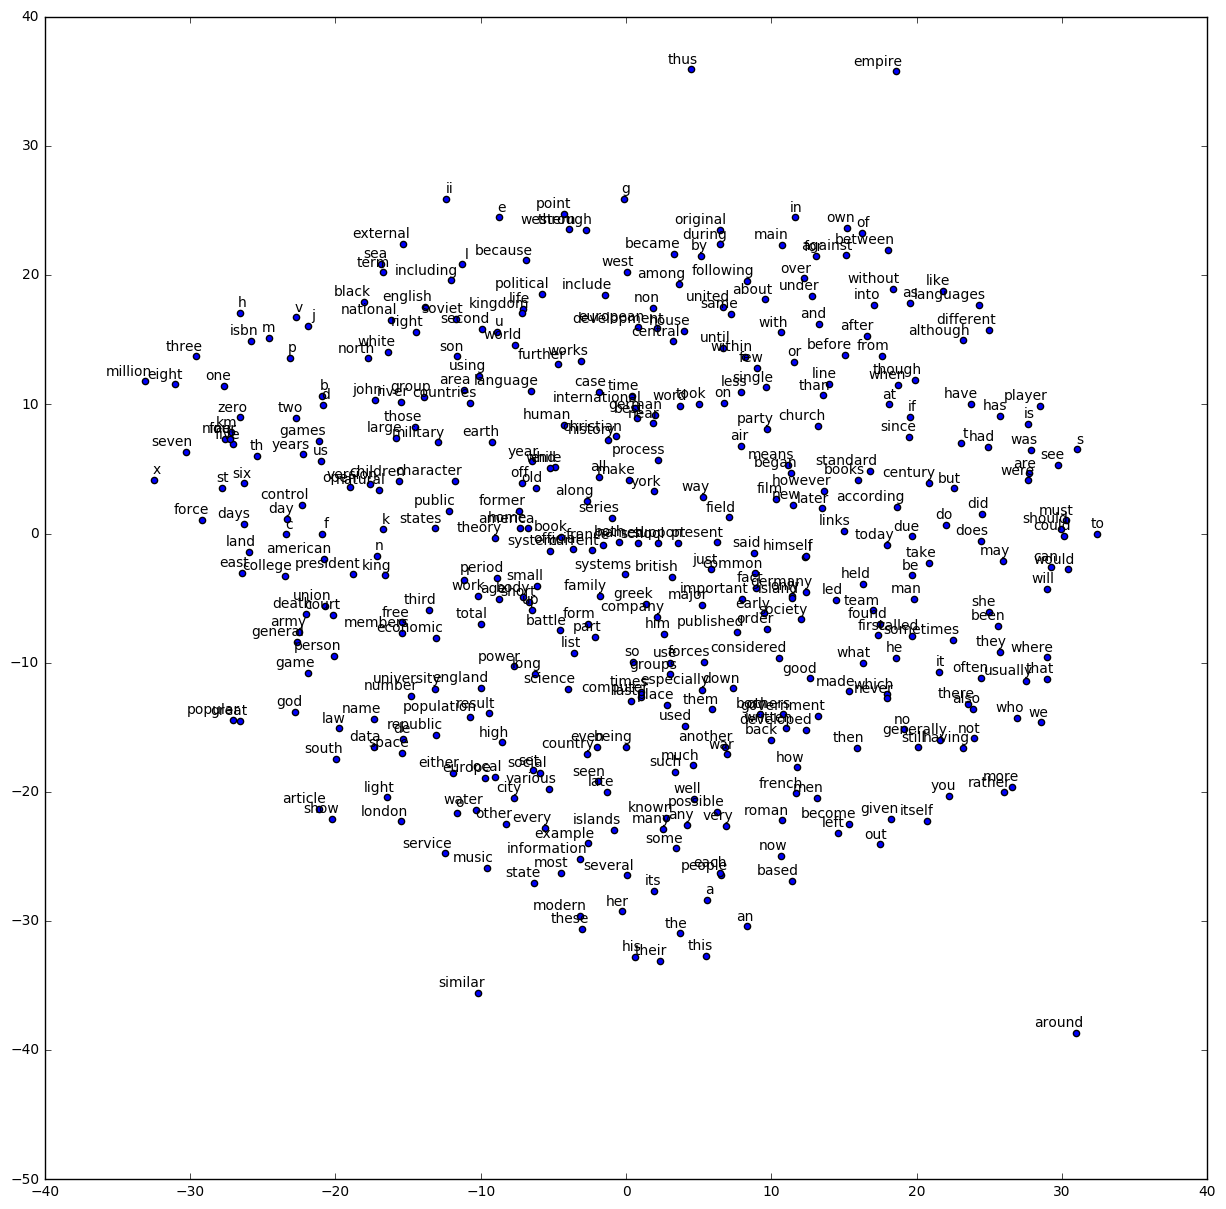

In [14]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
    pylab.show()

words = [index_to_word_dict[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)